# Simulated quantum annealing of MPS with Quantum TEA Leaves

/home/rattacaso/anaconda3/lib/python3.9/site-packages/qtealeaves/mpos/densempos.py:109: UserWarning: Adding term with zero-coupling.
  warnings.warn("Adding term with zero-coupling.")


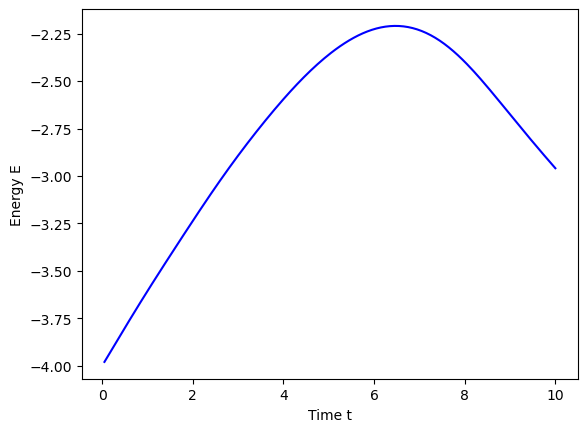

Sampled states: {'0100': 0.0019426712657953527, '0101': 0.4898547433352437, '1000': 2.13422366606153e-05, '1001': 0.006213241665578573, '1010': 0.48985474333523493, '1011': 0.0019426712657956147, '1100': 3.369988693879833e-06, '1101': 0.0019426712660577383}


In [3]:
"""
Minimal example of simulated quantum annealing with MPS states and TDVP.
"""

import qtealeaves as qtl
import os
from qtealeaves import modeling
import numpy as np
import matplotlib.pyplot as plt

# Define simaluated quantum annealing parameters
max_bond_dimension=16
annealing_time = 10
steps = 200
nn = 4

#Set the output folder
output_folder = "./qa/"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

#Build ising model, operators, observables, and convergence parameters
model = modeling.QuantumModel(1, "L", name="maxcut_ising")
model += modeling.TwoBodyTerm1D(["sz", "sz"], 1 ,strength = "J", prefactor = 1)
model += modeling.LocalTerm("sx", strength = "g", prefactor = 1)
ops = qtl.operators.TNSpin12Operators()
conv = qtl.convergence_parameters.TNConvergenceParameters(max_bond_dimension=max_bond_dimension)
obs = qtl.observables.TNObservables()
#Save states to file (needed for sampling)
obs += qtl.observables.TNState2File(output_folder, "F")

#Set python MPS QuantumGreenTeaSimulation
simulation = qtl.QuantumGreenTeaSimulation(model, ops, conv, obs,
                                    tn_type=6,
                                    tensor_backend=2,
                                    store_checkpoints=False,
                                    verbosity=False,
    )

# Define the qnnealing schedule (Note that with time_evolution_mode=1 something strange happends... why?)
quench = qtl.DynamicsQuench('t_grid', measurement_period=1, time_evolution_mode=2)
quench['g'] = lambda tt, params : 1.0 - 1.0 * (tt / annealing_time)
quench['J'] = lambda tt, params : 1.0 * (tt / annealing_time)
params = [{
    'L' : nn,
    'J' : 0,
    'g' : 1.0,
    't_grid' : [annealing_time/steps] * steps,
    'Quenches' : [quench],
    'exclude_from_hash' : ['Quenches'],
}]

# Run the simulation
simulation.run(params, delete_existing_folder=True)

# Get the observables
obs_quench = simulation.get_dynamic_obs(params[0])[0]
times = [entry['time'] for entry in obs_quench]
energies = [entry['energy'] for entry in obs_quench]
mps_file = obs_quench[-1][output_folder]


# Plot energy evolution
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(times, energies, 'b-')
ax1.set_xlabel('Time t')
ax1.set_ylabel('Energy E')
plt.savefig(os.path.join(output_folder, 'dyn_energy.pdf'))
plt.show()

# Sample computational states distribution
n_samples = 100
psi = qtl.emulator.MPS.read(mps_file, qtl.tensors.TensorBackend())
probs_dict = psi.meas_unbiased_probabilities(n_samples, do_return_samples=False, precision=15)
probs_dict = {conf : float(upper-lower) for conf, (lower, upper) in probs_dict.items()}
print("Sampled states:", probs_dict)
